# **Convolutional Network Example**

Author: PhD. Edwyn Javier Aldana
---



# **1. Loading Dataset**

In [1]:
import cv2
import os
import random
import numpy as np
from keras_preprocessing.image import ImageDataGenerator
import re
import pandas as pd



In [ ]:
###############################################
#Mount a directory on server in order to upload 
#dataset
###############################################
from google.colab import drive
drive.mount('/content/drive/')
%cd '/content/drive/My Drive/Colab Notebooks/data/images' 
#!unzip 'miml_dataset'
#!tar -xvf  'images.tar.gz' 
#!cd images/
#!pwd
#!rm  *.*



Define datasets: training, validation and test

In [8]:
#Load name files and class names from a CSV File
df=pd.read_csv('./miml_dataset/miml_labels_1.csv')
df.head()
columns=["desert", "mountains", "sea", "sunset", "trees"]



### **Computational representation of a RGB image**

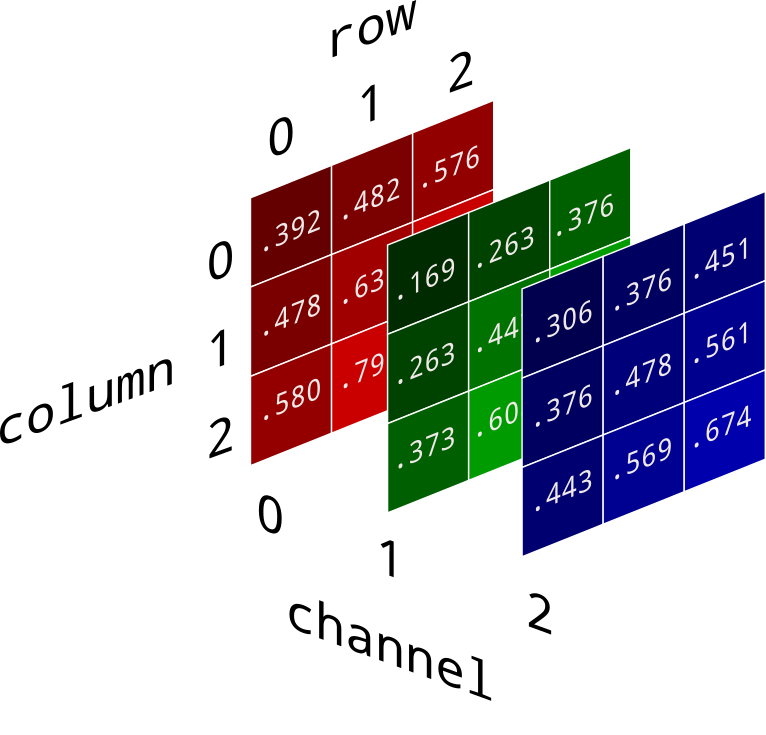

In [14]:
#Prepare train and test datasets (originally the images are 582x476 )
train_datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

#A generator creates an optimal structure in terms of memory
#to load the images
#Specifically a DataFrameIterator yielding tuples of (x, y)
#where x is a NumPy array containing a batch
#of images with shape (batch_size, *target_size, channels)
#and y is a NumPy array of corresponding labels
#In our case (16X64X64X3)
train_generator=train_datagen.flow_from_dataframe(
dataframe=df[:1800],
directory="./miml_dataset/images",
x_col="Filenames",
y_col=columns, #array previously created
batch_size=16,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(64,64))

valid_generator=test_datagen.flow_from_dataframe(
dataframe=df[1800:1900],
directory="./miml_dataset/images",
x_col="Filenames",
y_col=columns,
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(64,64))

test_generator=test_datagen.flow_from_dataframe(
dataframe=df[1900:],
directory="./miml_dataset/images",
x_col="Filenames",
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(64,64))

Found 1800 validated image filenames.
Found 100 validated image filenames.
Found 100 validated image filenames.


# **2. Designing a Convolutional Network**

In [23]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers, Sequential

#Input of the network
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same',
                 input_shape=(64,64,3)))
model.add(Activation('relu'))

#Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=(3, 3)))
model.add(Activation('relu'))
#Pooling Layer
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#Output layer, this depends on the number of classes,
#in our example we have 5 classes
model.add(Dense(5, activation='sigmoid'))
model.summary()
#Several hyper-parameters
model.compile(optimizers.RMSprop(lr=0.0001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_12 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 30752)            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# **3. Training Network**

In [24]:

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=5
)



/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
112/112 [==============================] - 37s 318ms/step - loss: 0.4762 - accuracy: 0.4546 - val_loss: 0.2783 - val_accuracy: 0.7083
Epoch 2/5
112/112 [==============================] - 36s 320ms/step - loss: 0.3983 - accuracy: 0.5846 - val_loss: 0.3568 - val_accuracy: 0.6979
Epoch 3/5
112/112 [==============================] - 35s 316ms/step - loss: 0.3699 - accuracy: 0.6110 - val_loss: 0.2533 - val_accuracy: 0.7500
Epoch 4/5
112/112 [==============================] - 35s 314ms/step - loss: 0.3480 - accuracy: 0.6485 - val_loss: 0.3067 - val_accuracy: 0.7188
Epoch 5/5
112/112 [==============================] - 35s 314ms/step - loss: 0.3304 - accuracy: 0.6575 - val_loss: 0.2814 - val_accuracy: 0.7604


# **4. Prediction**

In [28]:
test_generator.reset()
pred=model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)
#We obtain a probability vector (5-dimensional) for each test image
print(pred.shape)
pred



 11/100 [==>...........................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


100/100 [==============================] - 1s 11ms/step
(100, 5)


array([[9.58144665e-04, 1.28720820e-01, 7.68663406e-01, 4.57018614e-04,
        3.44590664e-01],
       [1.89021826e-02, 3.42877269e-01, 8.27720702e-01, 2.93924809e-02,
        4.40053642e-02],
       [5.87999821e-04, 2.10549533e-01, 1.33534104e-01, 2.18600035e-04,
        8.01023006e-01],
       [2.54517794e-03, 3.63767058e-01, 8.00465226e-01, 5.49441576e-03,
        1.27353728e-01],
       [1.26042962e-03, 1.39050275e-01, 7.69011080e-02, 1.56474113e-03,
        9.02408719e-01],
       [7.38650560e-04, 2.19696820e-01, 1.69233382e-01, 8.44240189e-04,
        8.60766768e-01],
       [4.13890183e-02, 4.61825877e-01, 6.64847732e-01, 1.71332955e-02,
        1.47687078e-01],
       [6.95496798e-04, 3.29442918e-02, 4.47758138e-02, 8.67200724e-05,
        9.76179779e-01],
       [5.76751769e-01, 5.94342947e-02, 3.78078520e-02, 1.18804872e-02,
        5.22830844e-01],
       [1.08680129e-03, 1.45429999e-01, 1.58308268e-01, 4.37170267e-04,
        8.93745422e-01],
       [6.38091564e-03, 7.1292

In [31]:
pred_bool = (pred >0.5)
predictions = pred_bool.astype(int)
columns=["desert", "mountains", "sea", "sunset", "trees"]

#columns should be the same order of y_col
results=pd.DataFrame(predictions, columns=columns)
results["Filenames"]=test_generator.filenames
ordered_cols=["Filenames"]+columns
results=results[ordered_cols]#To get the same column order
results.head()
#results.to_csv("results.csv",index=False)


Filenames  desert  mountains  sea  sunset  trees
0  1901.jpg       0          0    1       0      0
1  1902.jpg       0          0    1       0      0
2  1903.jpg       0          0    0       0      1
3  1904.jpg       0          0    1       0      0
4  1905.jpg       0          0    0       0      1